<a href="https://colab.research.google.com/github/gideonkipkorir/Credit_card_fraud-detection/blob/main/BPPipynb_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Loading Libriaries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import datetime
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

C:\Users\Prince\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
#function to read data
def readdata():
    df_train = pd.read_csv('CreditCardData.csv')
    return  df_train

## Data Understanding

In [ ]:
#Previewing the data
df_train = readdata()
df_train.head()

,Transaction ID,Date,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,#2546 884,13-Oct-20,23,MasterCard,Tap,£17,Online,Restaurant,United Kingdom,Russia,United Kingdom,F,36,Barclays,0
1,#2546 895,14-Oct-20,21,Visa,Tap,£28,Online,Gaming,United Kingdom,United Kingdom,United Kingdom,M,41,RBS,0
2,#2546 903,13-Oct-20,19,Visa,Tap,£8,Online,Subscription,United Kingdom,United Kingdom,United Kingdom,M,32,Barclays,0
3,#2546 906,14-Oct-20,9,MasterCard,PIN,£186,ATM,Entertainment,United Kingdom,United Kingdom,United Kingdom,F,65,Barclays,0
4,#2546 920,13-Oct-20,22,Visa,PIN,£86,Online,Children,United Kingdom,United Kingdom,United Kingdom,F,61,Monzo,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Transaction ID          100000 non-null  object
 1   Date                    100000 non-null  object
 2   Time                    100000 non-null  int64 
 3   Type of Card            100000 non-null  object
 4   Entry Mode              100000 non-null  object
 5   Amount                  100000 non-null  object
 6   Type of Transaction     100000 non-null  object
 7   Merchant Group          100000 non-null  object
 8   Country of Transaction  100000 non-null  object
 9   Shipping Address        100000 non-null  object
 10  Country of Residence    100000 non-null  object
 11  Gender                  100000 non-null  object
 12  Age                     100000 non-null  int64 
 13  Bank                    100000 non-null  object
 14  Fraud                   100000 non-nu

In [ ]:
df_train.shape #get dimension of of the dataset

(100000, 15)

In [ ]:
# Checking for null values
df_train.isnull().sum()

Transaction ID            0
Date                      0
Time                      0
Type of Card              0
Entry Mode                0
Amount                    0
Type of Transaction       0
Merchant Group            0
Country of Transaction    0
Shipping Address          0
Country of Residence      0
Gender                    0
Age                       0
Bank                      0
Fraud                     0
dtype: int64

## Data cleaning

In [ ]:
df_train.nunique() #checking for unique values in order to identify duplicates

Transaction ID            95687
Date                          2
Time                         24
Type of Card                  2
Entry Mode                    2
Amount                      396
Type of Transaction           3
Merchant Group               10
Country of Transaction        5
Shipping Address              5
Country of Residence          5
Gender                        2
Age                          65
Bank                          8
Fraud                         2
dtype: int64

In [ ]:
df_train = df_train.drop_duplicates(['Transaction ID'],keep = 'first')# dropping duplicates while retaining the firts values
df_train.shape

(95687, 15)

In [ ]:
# Feature transformation
df_train['Date'] = pd.to_datetime(df_train['Date']) #converting into datetime format
#converting into amount into numeric by removing "£" sign
df_train['Amount'] = df_train['Amount'].replace({r'\£':''}, regex = True).astype(int)
df_train['Fraud'] = df_train['Fraud'].astype(str)  # converting Fraud to categorical data from numeric

In [ ]:
df_train.info() #checking again after the conversion.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95687 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Transaction ID          95687 non-null  object        
 1   Date                    95687 non-null  datetime64[ns]
 2   Time                    95687 non-null  int64         
 3   Type of Card            95687 non-null  object        
 4   Entry Mode              95687 non-null  object        
 5   Amount                  95687 non-null  int32         
 6   Type of Transaction     95687 non-null  object        
 7   Merchant Group          95687 non-null  object        
 8   Country of Transaction  95687 non-null  object        
 9   Shipping Address        95687 non-null  object        
 10  Country of Residence    95687 non-null  object        
 11  Gender                  95687 non-null  object        
 12  Age                     95687 non-null  int64 

In [ ]:
num_df = df_train.select_dtypes(exclude=[object])# selecting numeric features
cat_df = df_train.select_dtypes(include=[object])# selecting categorical features

In [ ]:
num_df.describe() #summary statistics for numeric data

,Time,Amount,Age
count,95687.000000,95687.000000,95687.000000
mean,14.545393,112.482856,53.070772
std,5.324928,123.388712,18.749544
min,0.000000,5.000000,21.000000
25%,10.000000,17.000000,37.000000
50%,15.000000,30.000000,53.000000
75%,19.000000,208.000000,69.000000
max,23.000000,400.000000,85.000000


In [ ]:
cat_df.describe() #summary statistic for categorical data

,Transaction ID,Type of Card,Entry Mode,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Bank,Fraud
count,95687,95687,95687,95687,95687,95687,95687,95687,95687,95687,95687
unique,95687,2,2,3,10,5,5,5,2,8,2
top,#2546 884,Visa,PIN,Online,Children,United Kingdom,United Kingdom,United Kingdom,M,Barclays,0
freq,1,51552,47969,31996,10218,68028,58178,78313,48669,28641,88678


In [ ]:
cat_df.columns # column names for categorical features

Index(['Transaction ID', 'Type of Card', 'Entry Mode', 'Type of Transaction',
       'Merchant Group', 'Country of Transaction', 'Shipping Address',
       'Country of Residence', 'Gender', 'Bank', 'Fraud'],
      dtype='object')

## Exploratory Data Analysis
### Numeric data 

<AxesSubplot:xlabel='Age', ylabel='Density'>

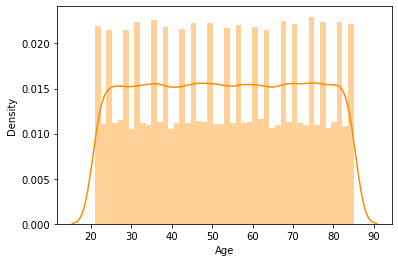

In [ ]:
# obtain the distribution of "Age"
sns.distplot(df_train["Age"],color='darkorange') 


<AxesSubplot:xlabel='Amount', ylabel='Density'>

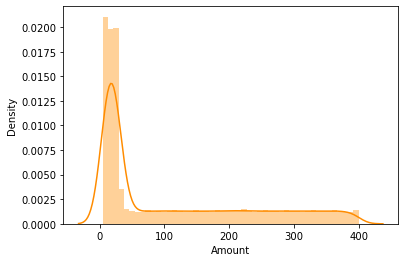

In [ ]:
## obtain the distribution of "Amount"
sns.distplot(df_train["Amount"],color='darkorange')

<AxesSubplot:xlabel='Age', ylabel='Count'>

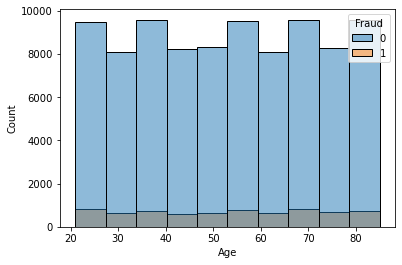

In [ ]:
# histogram of Age, based on Fraud
sns.histplot(x='Age',data=df_train,hue=df_train['Fraud'], bins= 10) 

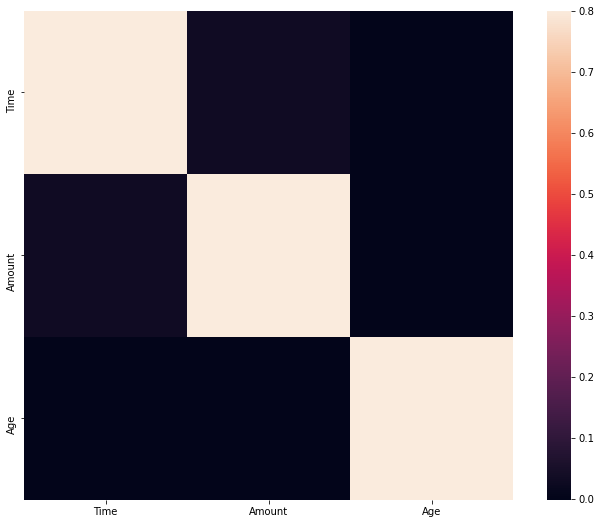

In [ ]:
#Coorelation analysis for numeric values
num_corr = num_df.corr(method='pearson', min_periods=1)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(num_corr, vmax=.8, square=True);

<AxesSubplot:xlabel='Fraud', ylabel='Amount'>

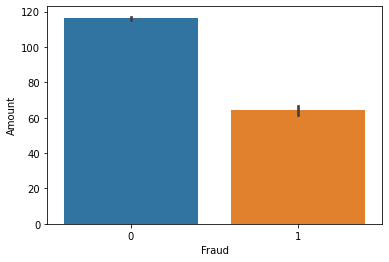

In [ ]:
#Average Amount of Fraud and non-Fraud transactions
ns.barplot(x='Fraud',y='Amount',data=df_train)

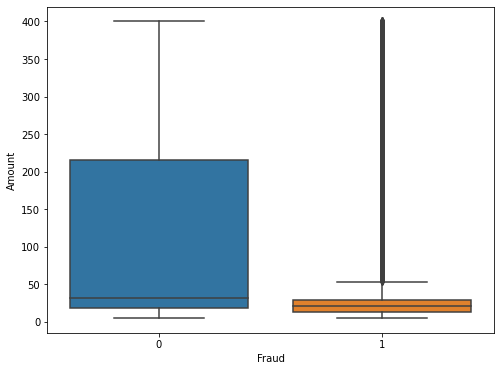

In [ ]:
#scatter plot Fraud/Amout
var = 'Fraud'
data = pd.concat([df_train['Amount'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='Amount', data=data) #A boxplot to check for outliers
fig.axis();

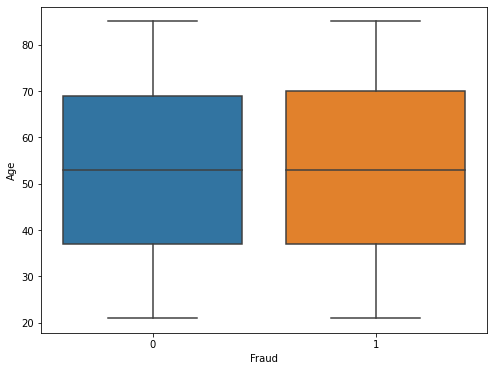

In [ ]:
#scatter plot Fraud/Age
var = 'Fraud'
data = pd.concat([df_train['Age'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='Age', data=data) #A boxplot to check for outliers
fig.axis();

In [ ]:
#Fuction to visualize univariate analysis
# parameters; dataframe (df) and a feature in the dataframe(var)
def cat_uni_plot(df, var):
    df[var].value_counts().plot.bar()

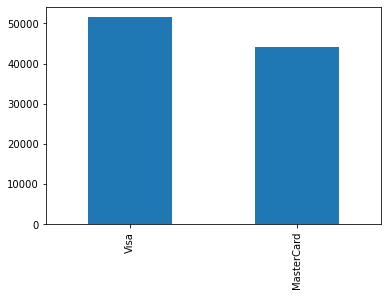

In [ ]:
cat_uni_plot(cat_df, 'Type of Card')

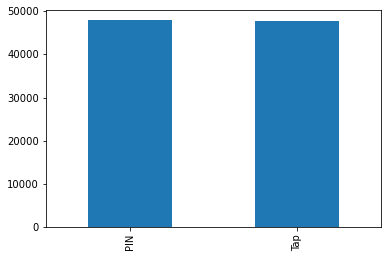

In [ ]:
cat_uni_plot(cat_df, 'Entry Mode')

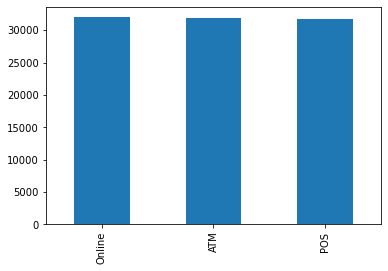

In [ ]:
cat_uni_plot(cat_df, 'Type of Transaction')

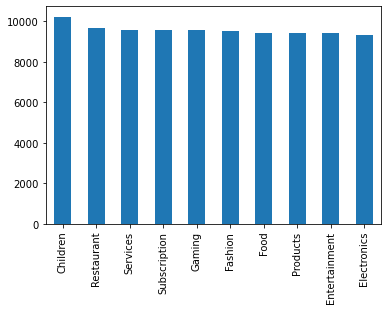

In [ ]:
cat_uni_plot(cat_df, 'Merchant Group')

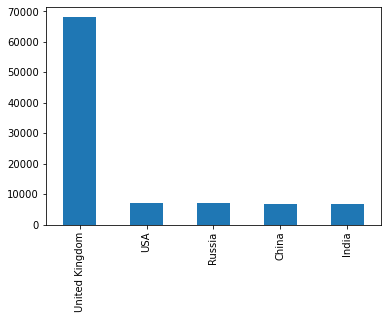

In [ ]:
cat_uni_plot(cat_df, 'Country of Transaction')

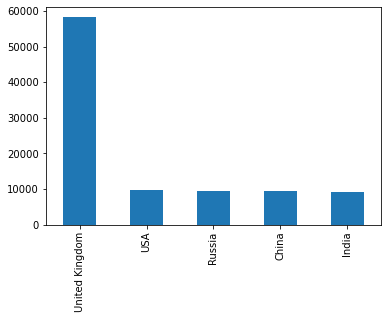

In [ ]:
cat_uni_plot(cat_df, 'Shipping Address')

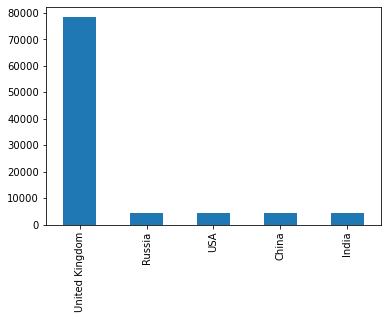

In [ ]:
cat_uni_plot(cat_df,'Country of Residence' )

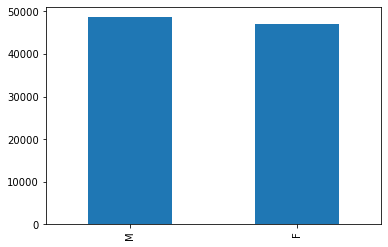

In [ ]:
cat_uni_plot(cat_df, 'Gender')

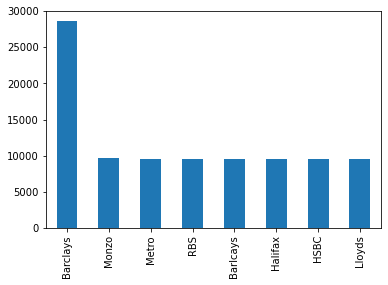

In [ ]:
cat_uni_plot(cat_df, 'Bank')

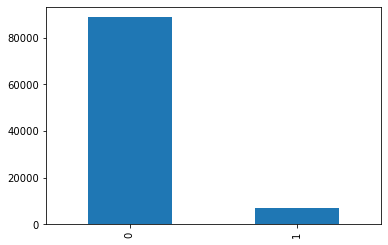

In [ ]:
cat_uni_plot(cat_df, 'Fraud')

In [ ]:
#Function to visualize bivariate analysis
#parameters; dataframe(df),hue="the dependent variable",first feature (var_1),second feature (var_2)
#The function plots 1 x 2 graph
def bivariate_plots(df, hue, var_1, var_2):
    fig, axs = plt.subplots(nrows= 1, ncols = 2, figsize=(8,5))
    plt.subplot(1,2,1)
    ax = sns.countplot(x=var_1, hue = hue,data=df, order=df[var_1].value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
    plt.subplot(1,2,2)
    ax = sns.countplot(x=var_2, hue = hue,data=df, order=df[var_2].value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
    plt.tight_layout()
    plt.show()

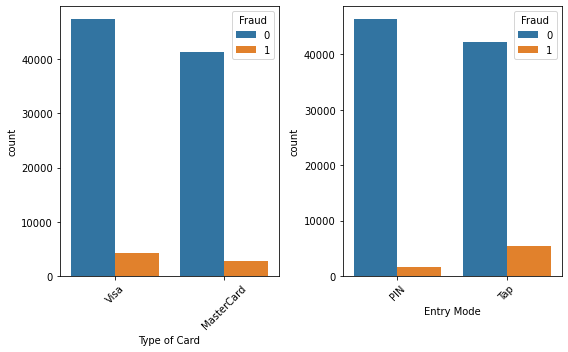

In [ ]:
bivariate_plots(cat_df, 'Fraud', 'Type of Card',	'Entry Mode')

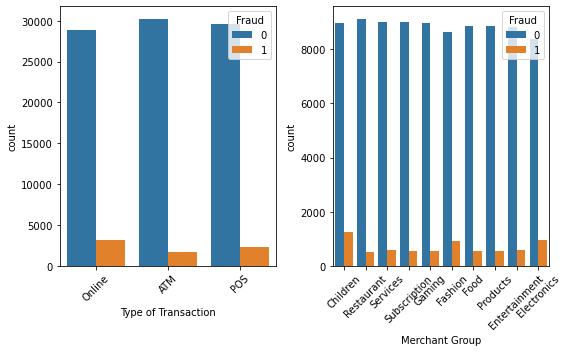

In [ ]:
bivariate_plots(cat_df, 'Fraud', 'Type of Transaction',	'Merchant Group')

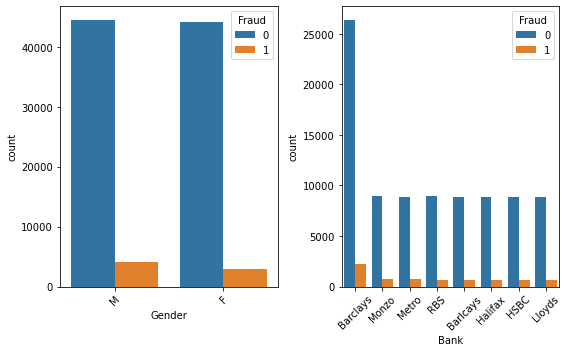

In [ ]:
bivariate_plots(cat_df, 'Fraud', 'Gender',	'Bank'	)

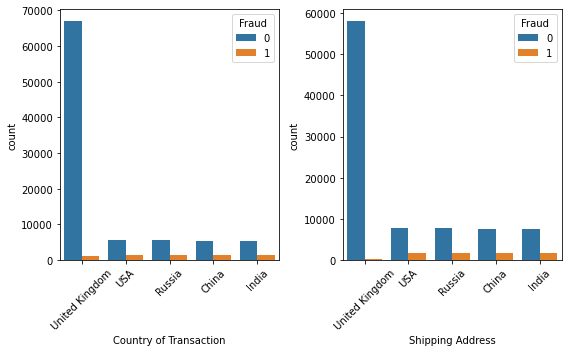

In [ ]:
bivariate_plots(cat_df, 'Fraud', 'Country of Transaction',	'Shipping Address'	)

### Multivariate analysis

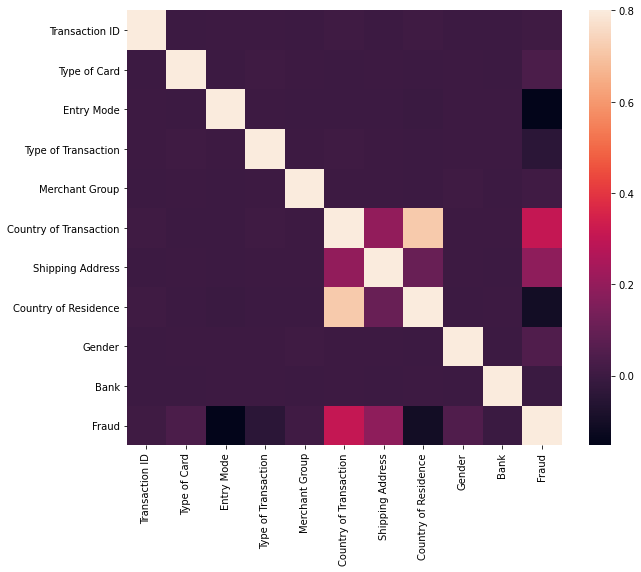

In [ ]:
#corrleation analysis of categorical data
corr = cat_df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, vmax=.8, square=True);


## Data Preparation

## feature enginneering

In [ ]:
#Combining 'Country of Transaction' and 'Shipping Address' to form a new feature
df_train['country_s_address'] = df_train['Country of Transaction'] + df_train['Shipping Address']
#Obtaining month_name as a new feature from Dates 
df_train['Month'] = df_train['Date'].dt.month_name()
#Obtaining week_day_name as a new feature from Dates 
df_train['Week_day_name'] =df_train['Date'].dt.day_name()

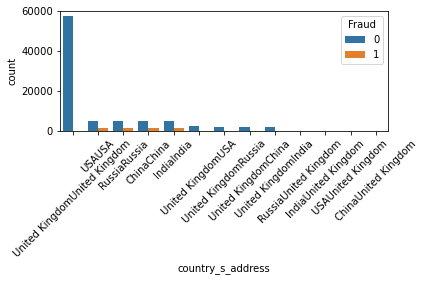

In [ ]:
#Lets explore how the new feature, 'country_s_address', is bale to classify flaud and non-fraud cases
ax = sns.countplot(x='country_s_address', hue = 'Fraud',data=df_train, order=df_train['country_s_address'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
plt.tight_layout()
plt.show()

**Observation**
* Cross-country transactions have no fradulent transactions; only transactions that within a jurisdiction have fraud

In [ ]:
#function to generalise Amounts of transaction into ; '>= 60' (less than 60 dollars), "61-120" (between 60 and 120 dollars), and ">120" (Amounts above 120 dollars)
def amount_classifier(df, feature):
  clas = []
  for val in df[feature]:
    if val <= 60:
      clas.append('>= 60')
    elif val >60 and val<=120:
      clas.append("61-120")
    elif val>120:
      clas.append(">120")
    else:
      clas.append('null')
  df['class_amount'] = clas
  return df

In [ ]:
df_train = amount_classifier(df_train, 'Amount') #calling the function

### Data preprocessing

In [ ]:
le = preprocessing.LabelEncoder() #label encoding using Labelencoder
df_train['Fraud'] =le.fit_transform(df_train['Fraud']) 

In [ ]:
 #label encoding categorical data using Labelencoder
df_train[['Transaction ID',  'Type of Card', 'Entry Mode',
       'Type of Transaction', 'Merchant Group', 'Country of Transaction',
       'Shipping Address', 'Country of Residence', 'Gender', 'Bank',
       'country_s_address', 'class_amount','Month', 'Week_day_name']]=df_train[['Transaction ID',  'Type of Card', 'Entry Mode',
       'Type of Transaction', 'Merchant Group', 'Country of Transaction',
       'Shipping Address', 'Country of Residence', 'Gender', 'Bank',
       'country_s_address', 'class_amount','Month', 'Week_day_name']].apply(le.fit_transform)


In [ ]:
#Spliting data into targets (y) and predictors (x)
y = df_train['Fraud']
x = df_train.drop(['Fraud','Date','Transaction ID'],axis = 1)

In [ ]:
x.columns

Index(['Time', 'Type of Card', 'Entry Mode', 'Amount', 'Type of Transaction',
       'Merchant Group', 'Country of Transaction', 'Shipping Address',
       'Country of Residence', 'Gender', 'Age', 'Bank', 'country_s_address',
       'Month', 'Week_day_name', 'class_amount'],
      dtype='object')

In [ ]:
#Spliting the data into training and test data set using skit-learn's train_split function.
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2, random_state =11)

## XGboost classifier

In [ ]:
#configuring the parameters of our XGBoost Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [ ]:
y_pred = model.predict(x_test)# using the XGBoost classifier to make prediction

In [ ]:
accuracy = accuracy_score(y_test, y_pred) #measuring the accuracy
accuracy

0.9866234716271293

In [ ]:
confusion_matrix(y_test, y_pred) # measuring accuracy using Confusion matrix 

array([[17729,    49],
       [  207,  1153]], dtype=int64)

* True positive rate (or sensitivity): TPR=TP/(TP+FN) = 99.72%
* False positive rate: FPR=FP/(FP+TN) = 15.22 %

## Random Forest

In [ ]:
clf=RandomForestClassifier(n_estimators=300) #configuring the parameters of our RandomForest Classifier
clf = clf.fit(x_train,y_train)

In [ ]:
y_pred = clf.predict(x_test))# using the model to make prediction

In [ ]:
confusion_matrix(y_test, y_pred) # measuring accuracy using Confusion matrix

array([[17752,    26],
       [  226,  1134]], dtype=int64)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9868324798829554

* True positive rate (or sensitivity): TPR=TP/(TP+FN) = 99.85%
* False positive rate: FPR=FP/(FP+TN) = 16.62 %